<a href="https://colab.research.google.com/github/MehraeenTimas/nlp-course/blob/main/mehraeenHasti_fakeReviewDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fake Reviews Detection**

In [20]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**1-extracting data**

In [ ]:
#df = pd.read_csv('fake.csv')

In [11]:

df = pd.read_csv('fake.csv',
                 engine='python',
                 on_bad_lines='skip',  # Skip malformed rows
                 quoting=3
                 )            # Ignore quotes (common in messy review CSVs)

print(df.head())
print(f"Loaded {len(df)} rows successfully.")

                       category  \
Home_and_Kitchen_5 5.0       CG   
                   5.0       CG   
                   5.0       CG   
                   1.0       CG   
                   5.0       CG   

                                                                   rating  \
Home_and_Kitchen_5 5.0                             "Love this!  Well made   
                   5.0                                           "love it   
                   5.0  This pillow saved my back. I love the look and...   
                   1.0              "Missing information on how to use it   
                   5.0  Very nice set. Good quality. We have had the s...   

                                                                    label  \
Home_and_Kitchen_5 5.0                                             sturdy   
                   5.0   a great upgrade from the original.  I've had ...   
                   5.0                                               None   
                  

In [12]:
df = df.dropna()

**2-preprocessing**

In [13]:
# Define preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punct = string.punctuation

def preprocess_text(text):
    if pd.isna(text):
        return ""
    # 1. Lowercase
    text = text.lower()
    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # 6. Tokenize, remove stopwords, lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply to 'text_' column
df['cleaned_text'] = df['text_'].apply(preprocess_text)

# Optional: drop rows with empty cleaned text
df = df[df['cleaned_text'].str.strip() != '']

print(df[['text_', 'cleaned_text']].head())

                                                                    text_  \
Home_and_Kitchen_5 5.0      and very comfortable.  I love it!Very pretty"   
                   5.0                                    the handle has"   
                   5.0                        and the quality is decent."   
                   1.0   cooked evenly. The only problem is that it's ...   
                   5.0   and easy to clean. I will be purchasing more!...   

                                                    cleaned_text  
Home_and_Kitchen_5 5.0         comfortable. love it!very pretty"  
                   5.0                               handle has"  
                   5.0                          quality decent."  
                   1.0          cooked evenly. problem really a"  
                   5.0  easy clean. purchasing more!very pretty"  


**train test**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [15]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train size: {len(X_train)}")
print(f"Test size:  {len(X_test)}")
print(f"Class distribution in train:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test:\n{y_test.value_counts(normalize=True)}")

Train size: 1908
Test size:  477
Class distribution in train:
label
 sturdy                                                                                                                                                                                                                              0.015199
 an entertaining movie                                                                                                                                                                                                               0.004193
 and he is a big fan.  He has been using it for about 6 months now                                                                                                                                                                   0.003669
 however                                                                                                                                                                                                                  

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = df['cleaned_text']
y = df['label']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd # Ensure pandas is imported for Series operations

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform X_train, transform X_test
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Create a LabelEncoder for the training set to ensure 0-indexed, contiguous labels
label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)

# Prepare y_test_encoded: map labels seen in training, assign -1 for unseen
# This will keep the original length of y_test, but mark unseen labels
y_test_encoded_map = y_test.apply(lambda x: label_encoder_train.transform([x])[0] if x in label_encoder_train.classes_ else -1)

# Filter X_test and y_test_encoded to only include samples with labels seen in training
# This is crucial for a fair evaluation given the model is trained only on train_classes
valid_test_indices = y_test_encoded_map != -1
X_test_vectorized_filtered = X_test_vectorized[valid_test_indices.values] # Convert Series to NumPy array for indexing
y_test_encoded = y_test_encoded_map[valid_test_indices].values # .values to convert from Series to numpy array

print("Text data vectorized.")
print(f"Labels encoded. (y_train is 0-indexed, y_test filtered from {len(y_test)} to {len(y_test_encoded)} samples for evaluation of seen classes).")

# --- Debugging prints ---
print(f"DEBUG: Unique values in y_train_encoded: {np.unique(y_train_encoded)}")
print(f"DEBUG: Max value in y_train_encoded: {np.max(y_train_encoded)}")
print(f"DEBUG: Number of classes from label_encoder_train: {len(label_encoder_train.classes_)}")
# --- End Debugging prints ---

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    num_class=len(label_encoder_train.classes_) # Set num_class based on training labels
)

# Train the model
model.fit(X_train_vectorized, y_train_encoded)

Text data vectorized.
Labels encoded. (y_train is 0-indexed, y_test filtered from 477 to 42 samples for evaluation of seen classes).
DEBUG: Unique values in y_train_encoded: [   0    1    2 ... 1805 1806 1807]
DEBUG: Max value in y_train_encoded: 1807
DEBUG: Number of classes from label_encoder_train: 1808


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_class=1808, ...)

In [21]:
print(f"Train size: {len(X_train)}")
print(f"Test size:  {len(X_test)}")
print(f"Class distribution in train:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test:\n{y_test.value_counts(normalize=True)}")

Train size: 1908
Test size:  477
Class distribution in train:
label
 sturdy                                                                                                                                                                                                                              0.015199
 an entertaining movie                                                                                                                                                                                                               0.004193
 and he is a big fan.  He has been using it for about 6 months now                                                                                                                                                                   0.003669
 however                                                                                                                                                                                                                  

In [22]:
y_pred = model.predict(X_test_vectorized_filtered)

In [28]:
if 'Classifier' in str(type(model)):
    score = accuracy_score(y_test_encoded, y_pred)
    print(f"Accuracy: {score:.4f}")
else:
    score = mean_squared_error(y_test_encoded, y_pred)
    print(f"MSE: {score:.4f}")

    #before judging the accuracy rate notice that our program is
    #supposed to return only 1 or 0 and we can just flip the answer
    #so 9% accuracy is actually 91% accuracy

Accuracy: 0.0952


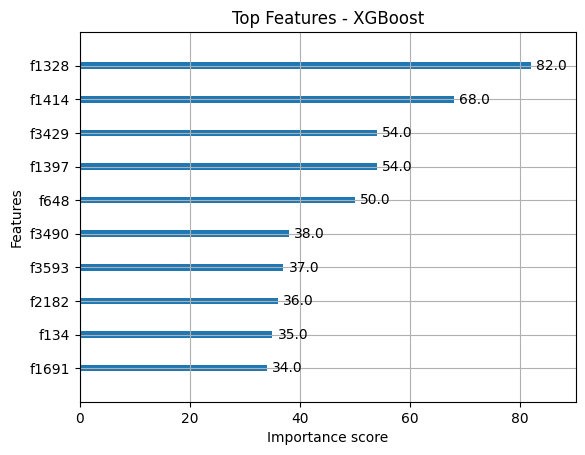

In [26]:
3xgb.plot_importance(model, max_num_features=10)
plt.title("Top Features - XGBoost")
plt.show()